In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr, spearmanr


# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

In [4]:
df = (
    pd.read_csv("1st-dataset.csv", parse_dates=["game_date"])  # 날짜 파싱
)

sportsType = "전체"

if sportsType in ["야구", "축구", "농구", "배구"]:
    df = df[df['sports_type'] == sportsType]

df.info()

print(len(df[df["audience"]==0]))
#df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3623 entries, 0 to 3622
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         3623 non-null   int64         
 1   stadium_code    3623 non-null   object        
 2   sports_type     3623 non-null   object        
 3   game_date       3623 non-null   datetime64[ns]
 4   day_of_week     3623 non-null   object        
 5   is_holiday      3623 non-null   int64         
 6   start_time      3623 non-null   object        
 7   home_team_win   3623 non-null   int64         
 8   match_type      3602 non-null   object        
 9   audience        2285 non-null   float64       
 10  region          3623 non-null   object        
 11  accident_count  2923 non-null   float64       
 12  injury_count    2923 non-null   float64       
 13  death_count     2923 non-null   float64       
 14  temperature     3623 non-null   float64       
 15  prec

/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL})

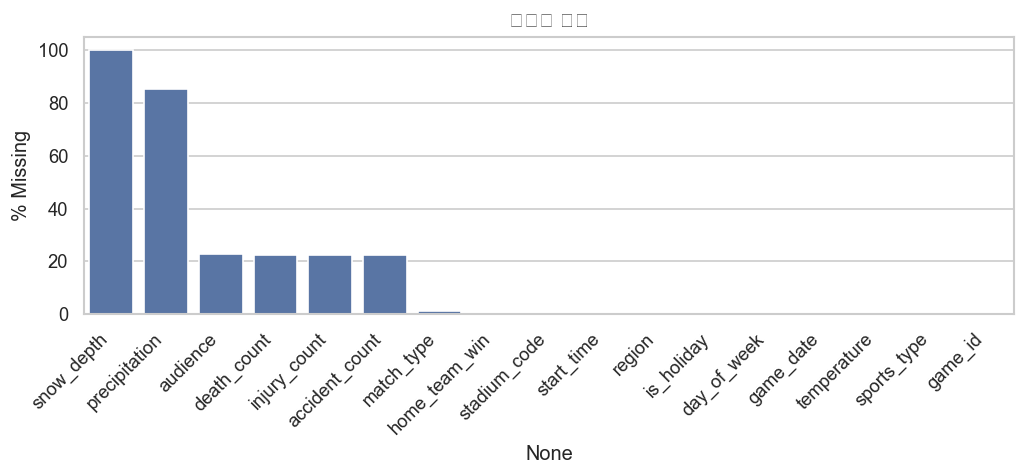

In [3]:
# 품질·결측치 시각화 ---------------
na_pct = df.isna().mean().mul(100).sort_values(ascending=False)
plt.figure(figsize=(10,3))
sns.barplot(x=na_pct.index, y=na_pct.values)
plt.xticks(rotation=45, ha="right"); plt.ylabel("% Missing")
plt.title("결측치 비율"); plt.show()

In [4]:
# 2. region별 평균값 계산
region_mean = df.groupby('region')['audience'].mean()
print(region_mean)

def impute_with_noise(row):
    if row['audience'] == 0:
        mean_val = region_mean.get(row['region'], np.nan)
        if pd.notna(mean_val):
            noise = np.random.normal(loc=0, scale=0.1)  # 평균 0, 표준편차 0.1 → ±10% 정도 오차
            return mean_val * (1 + noise)
    return row['audience']

# 4. 적용
df['audience'] = df.apply(impute_with_noise, axis=1)

region
경기 수원시     10694.543750
경기 이천시              NaN
경남 창원시      9285.441718
광주 북구      13906.282051
대구 수성구     16267.680000
대전 중구       9546.604027
부산 동래구     15678.246753
서울 구로구      9815.903846
서울 송파구     16939.218023
울산 남구       8023.300000
인천 미추홀구    15469.792208
충북 청주시      8706.200000
Name: audience, dtype: float64


In [5]:
df.groupby('region')['audience'].mean()
print(len(df[df["audience"]==0]))

filtered_df = df[df['audience'] == 0]
print(filtered_df)

0
Empty DataFrame
Columns: [game_id, stadium_code, sports_type, game_date, day_of_week, is_holiday, start_time, home_team_win, match_type, audience, region, accident_count, injury_count, death_count, temperature, precipitation, snow_depth]
Index: []


In [6]:
df.match_type.unique()
# 기본 치환: '페넌트레이스'·'순위결정전'(오탈자 '순위결정정' 포함)·'0' --> '정규시즌'
df["match_type"] = (
    df["match_type"]
        .replace({"페넌트레이스": "정규시즌",
                  "순위결정전": "정규시즌",
                  "순위결정정": "정규시즌",   # 오타까지 함께 처리
                  '조별리그' : "정규시즌",
                  "0": "정규시즌"})
        # ➋ 라운드 표기(1R ~ 33R 등) → 정규시즌
        .str.replace(r"^\d+R$", "정규시즌", regex=True)
)

df["match_type"] = (
    df["match_type"]
        .replace({'와일드카드':"포스트시즌",
                '준플레이오프':"포스트시즌", 
                '플레이오프':"포스트시즌", 
                '한국시리즈':"포스트시즌",
                '파이널 라운드A':"포스트시즌",
                '파이널 라운드B':"포스트시즌",
                '챔피언결정전':"포스트시즌", 
                '준결승':"포스트시즌", 
                '결승':"포스트시즌"})
)
# 결과 확인
print(df["match_type"].unique())

['시범경기' '정규시즌' nan '올스타전' '포스트시즌']


In [19]:
df[df['audience'].isnull()]

,game_id,stadium_code,sports_type,game_date,day_of_week,is_holiday,start_time,home_team_win,match_type,audience,region,accident_count,injury_count,death_count,temperature,precipitation,snow_depth,start_hour,day_of_week_cat
0,1,DJ02,야구,2023-03-13,월,0,0 days 14:00:00,1,시범경기,NaN,대전 중구,3.0,4.0,0.0,8.8,NaN,NaN,14,월
1,2,SO04,야구,2023-03-13,월,0,0 days 14:00:00,0,시범경기,NaN,서울 구로구,NaN,NaN,NaN,6.6,NaN,NaN,14,월
2,3,CW01,야구,2023-03-13,월,0,0 days 14:00:00,0,시범경기,NaN,경남 창원시,NaN,NaN,NaN,8.3,NaN,NaN,14,월
3,4,BS02,야구,2023-03-13,월,0,0 days 14:00:00,0,시범경기,NaN,부산 동래구,2.0,2.0,0.0,9.8,NaN,NaN,14,월
4,5,DG03,야구,2023-03-13,월,0,0 days 14:00:00,1,시범경기,NaN,대구 수성구,5.0,8.0,0.0,8.9,NaN,NaN,14,월
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,2028,BS02,야구,2024-08-30,토,0,0 days 18:00:00,1,정규시즌,NaN,부산 동래구,2.0,2.0,0.0,30.6,NaN,NaN,18,토
2065,2029,DJ02,야구,2024-08-30,토,0,0 days 18:00:00,1,정규시즌,NaN,대전 중구,1.0,3.0,0.0,30.9,NaN,NaN,18,토
2066,2030,SO05,야구,2024-08-30,토,0,0 days 18:00:00,0,정규시즌,NaN,서울 송파구,11.0,13.0,0.0,31.4,NaN,NaN,18,토
2067,2031,SU03,야구,2024-08-31,일,1,0 days 18:00:00,1,정규시즌,NaN,경기 수원시,18.0,24.0,0.0,28.9,NaN,NaN,18,일


In [12]:
# 문자열을 timedelta64로 변환
df['start_time'] = pd.to_timedelta(df['start_time'])

# 시작시각 → 시간 숫자(0~23) 추출
df["start_hour"] = df['start_time'].dt.components['hours']

# 요일 숫자 & 카테고리 정렬
weekday_map = ["월","화","수","목","금","토","일"]
df["day_of_week_cat"] = pd.Categorical(df["day_of_week"],
                                       categories=weekday_map, ordered=True)

# 수치/범주 변수 분리
num_cols  = ["injury_count","death_count",
             "temperature","precipitation","start_hour", "audience"]
cat_cols  = ["region","sports_type","match_type",
             "home_team_win","is_holiday","day_of_week_cat"]


/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL})

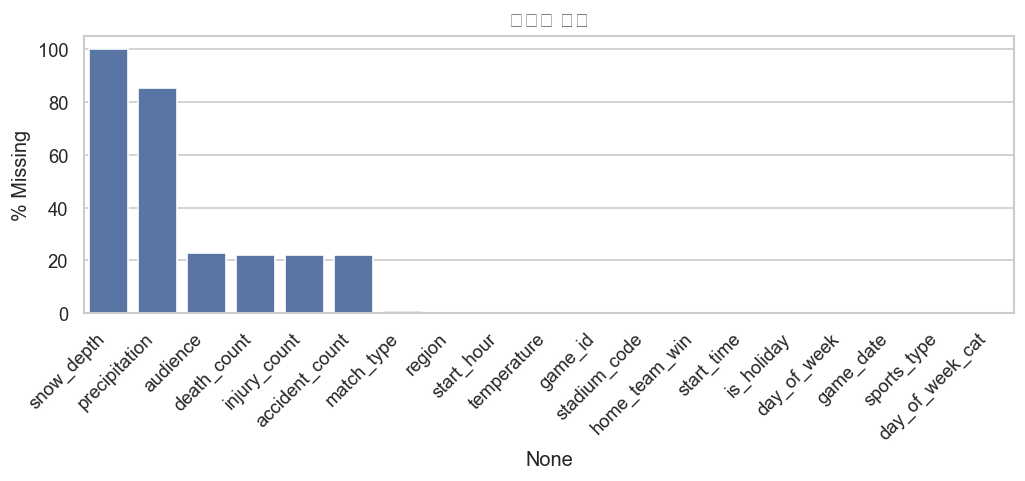

In [13]:
# -------------------- 3-1. 품질·결측치 시각화 ---------------
na_pct = df.isna().mean().mul(100).sort_values(ascending=False)
plt.figure(figsize=(10,3))
sns.barplot(x=na_pct.index, y=na_pct.values)
plt.xticks(rotation=45, ha="right"); plt.ylabel("% Missing")
plt.title("결측치 비율"); plt.show()

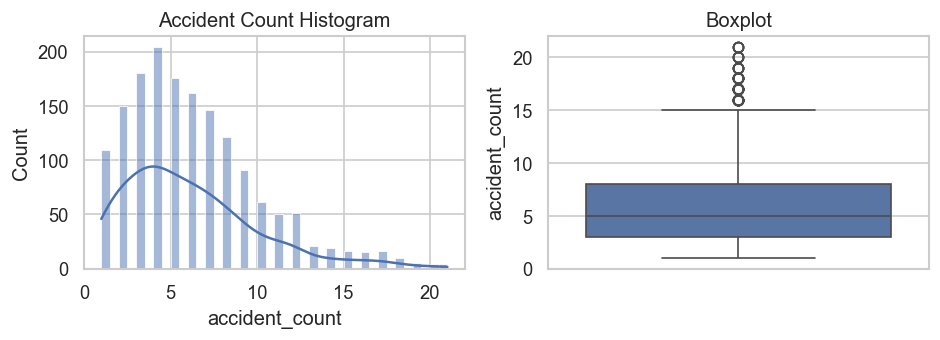

In [20]:
# -------------------- 3-2. 사고건수 기본 분포 ----------------
fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.histplot(df["accident_count"], bins=40, kde=True, ax=ax[0])
ax[0].set_title("Accident Count Histogram")
sns.boxplot(y=df["accident_count"], ax=ax[1])
ax[1].set_title("Boxplot")
plt.tight_layout(); plt.show()

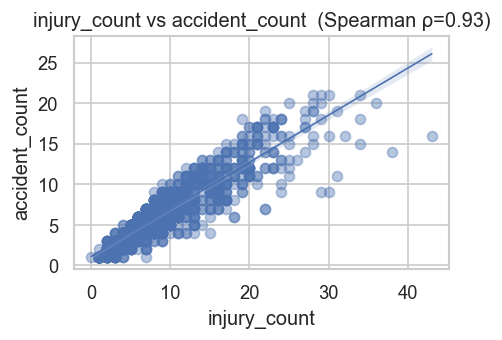

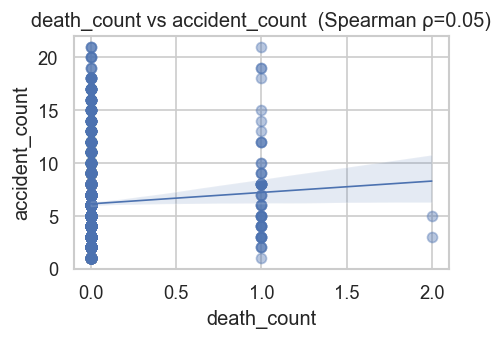

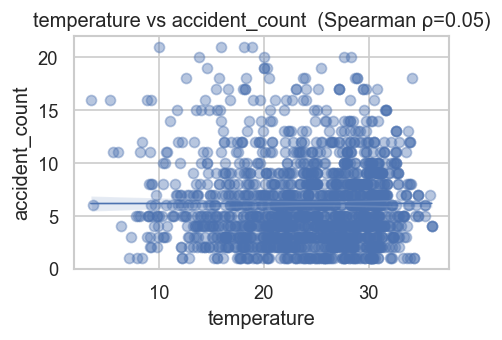

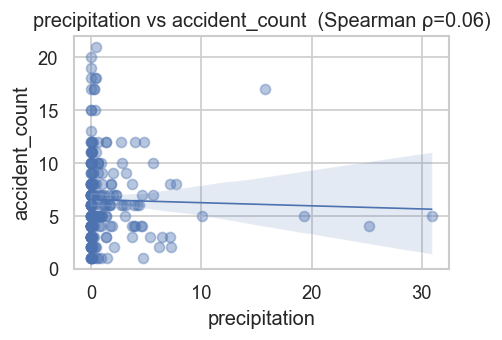

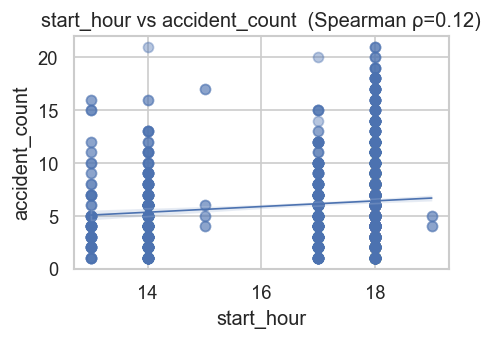

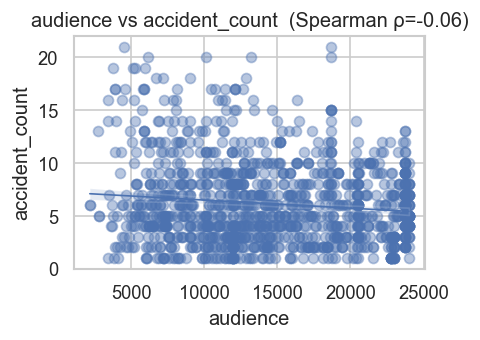

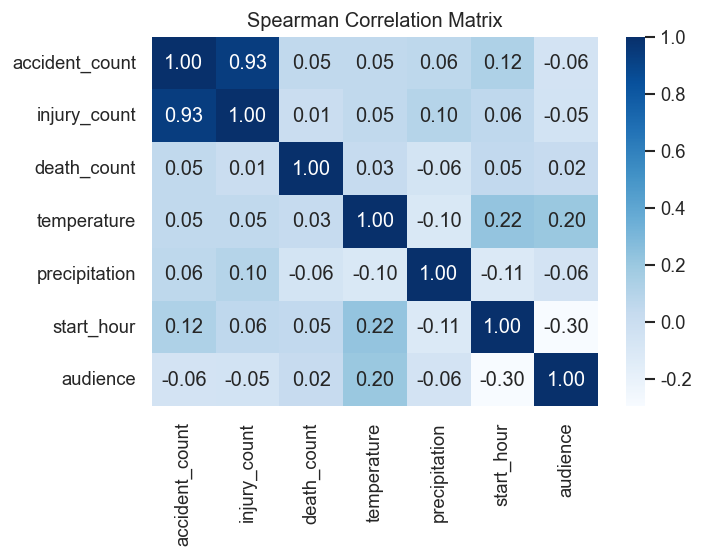

In [21]:
# -------------------- 3-3. 수치형 ↔ 사고건수 관계 ------------
# (a) 산점도 + 선형회귀선
for col in num_cols:
    plt.figure(figsize=(4,3))
    sns.regplot(x=col, y="accident_count", data=df,
                scatter_kws={'alpha':0.4}, line_kws={'lw':1})
    r, p = spearmanr(df[col], df["accident_count"], nan_policy='omit')
    plt.title(f"{col} vs accident_count  (Spearman ρ={r:.2f})")
    plt.tight_layout(); plt.show()

# (b) 상관계수 히트맵
corr = df[["accident_count"] + num_cols].corr(method="spearman")
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Spearman Correlation Matrix"); plt.show()

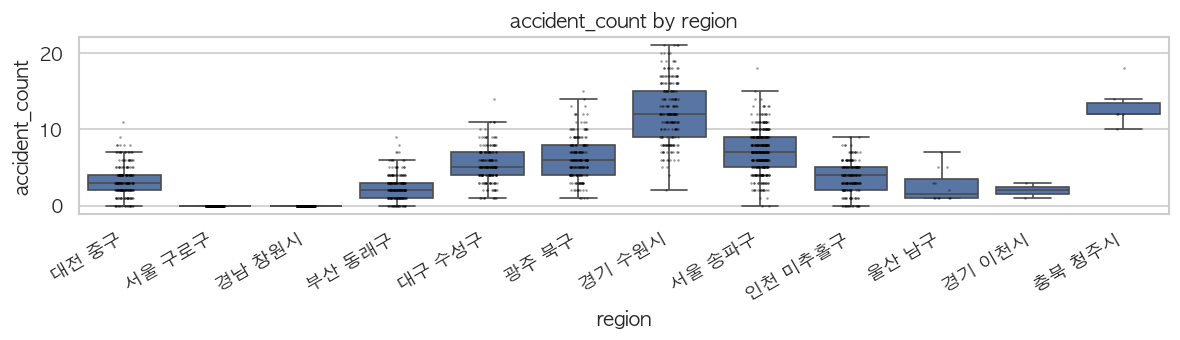

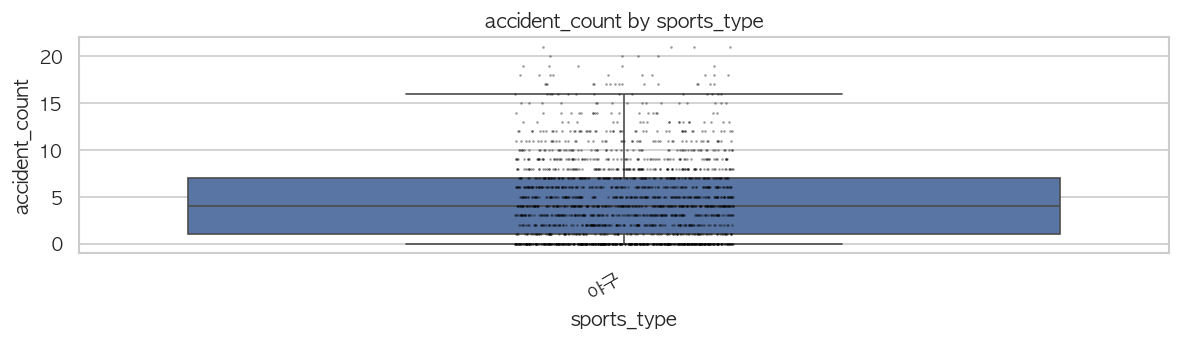

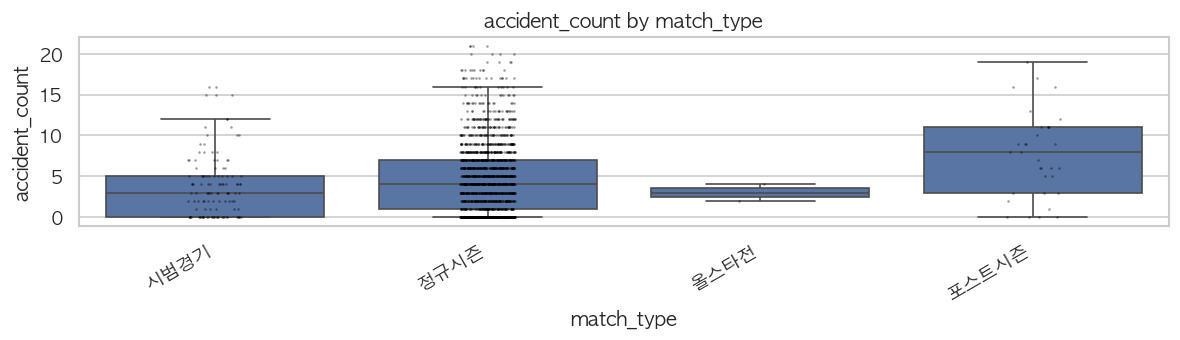

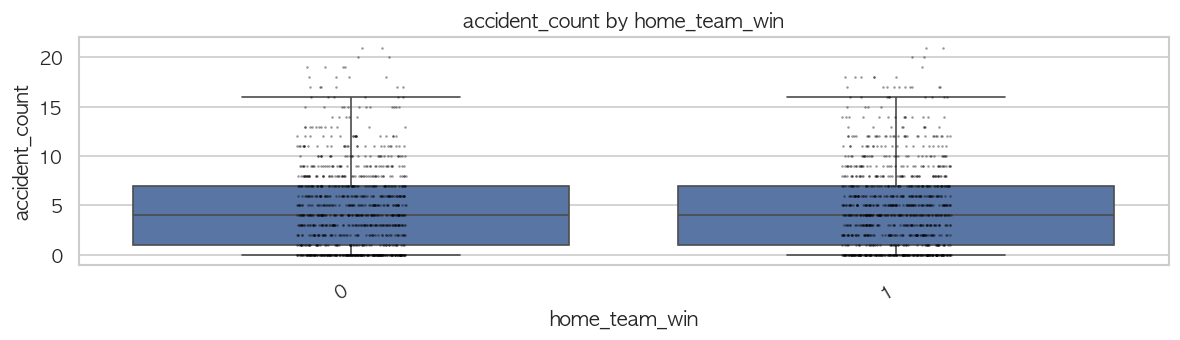

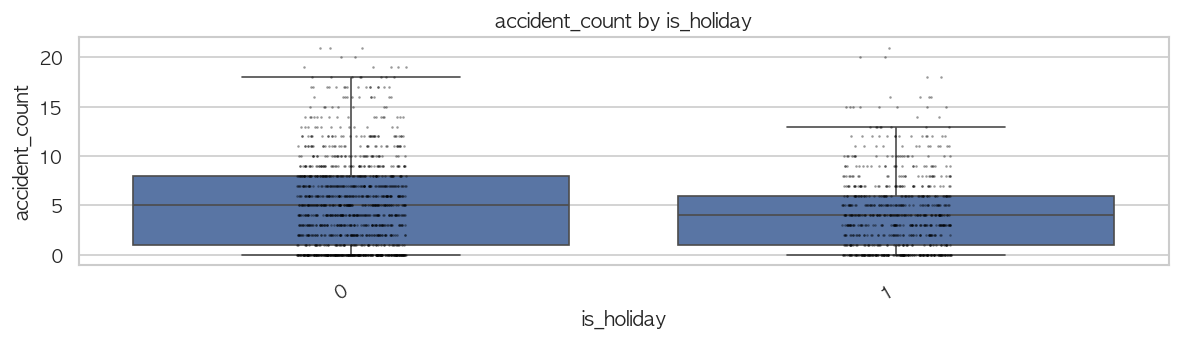

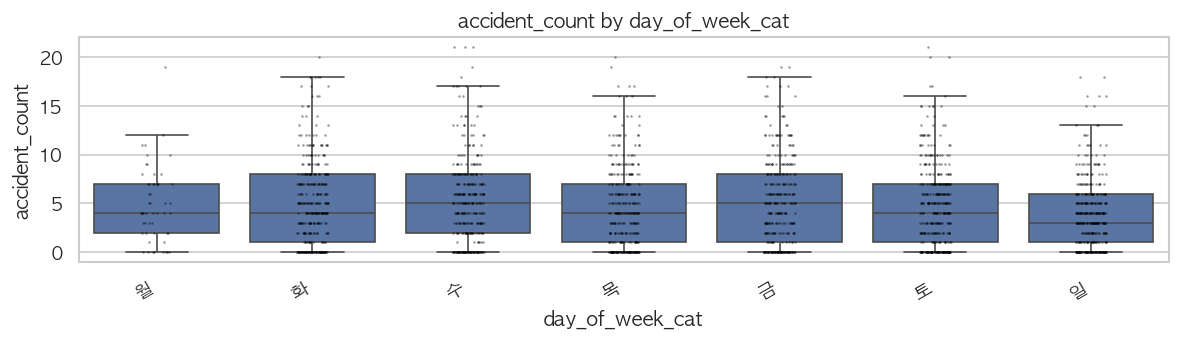

In [9]:
# -------------------- 3-4. 범주형 ↔ 사고건수 -----------------
# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

for col in cat_cols:
    plt.figure(figsize=(10,3))
    sns.boxplot(x=col, y="accident_count", data=df,
                showfliers=False)
    sns.stripplot(x=col, y="accident_count", data=df,
                  color='black', size=1.5, alpha=0.4)
    plt.title(f"accident_count by {col}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout(); plt.show()

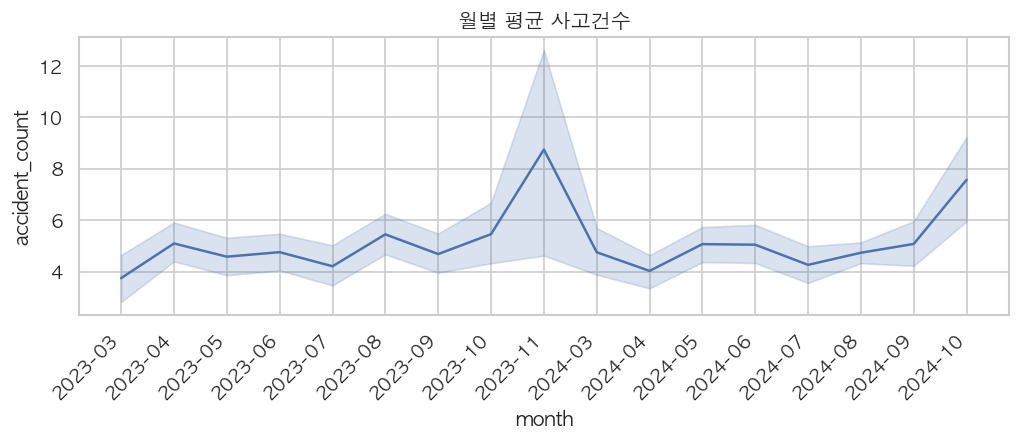

/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_76658/533077419.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="start_hour", y="accident_count", data=df,


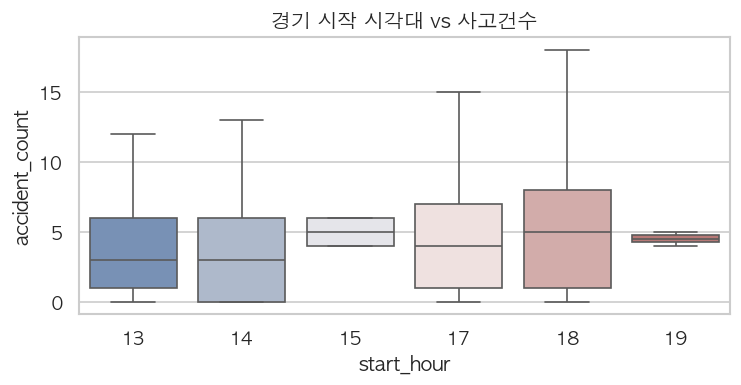

In [43]:
# -------------------- 3-5. 시계열 & 시간대 ------------------
# (a) 월별 평균
df["month"] = df["game_date"].dt.to_period("M")
plt.figure(figsize=(10,3))
sns.lineplot(x=df["month"].astype(str), y="accident_count",
             estimator="mean", errorbar="ci", data=df)
plt.xticks(rotation=45, ha="right"); plt.title("월별 평균 사고건수"); plt.show()

# (b) 시작 시간대별 분포
plt.figure(figsize=(7,3))
sns.boxplot(x="start_hour", y="accident_count", data=df,
            palette="vlag", showfliers=False)
plt.title("경기 시작 시각대 vs 사고건수"); plt.show()

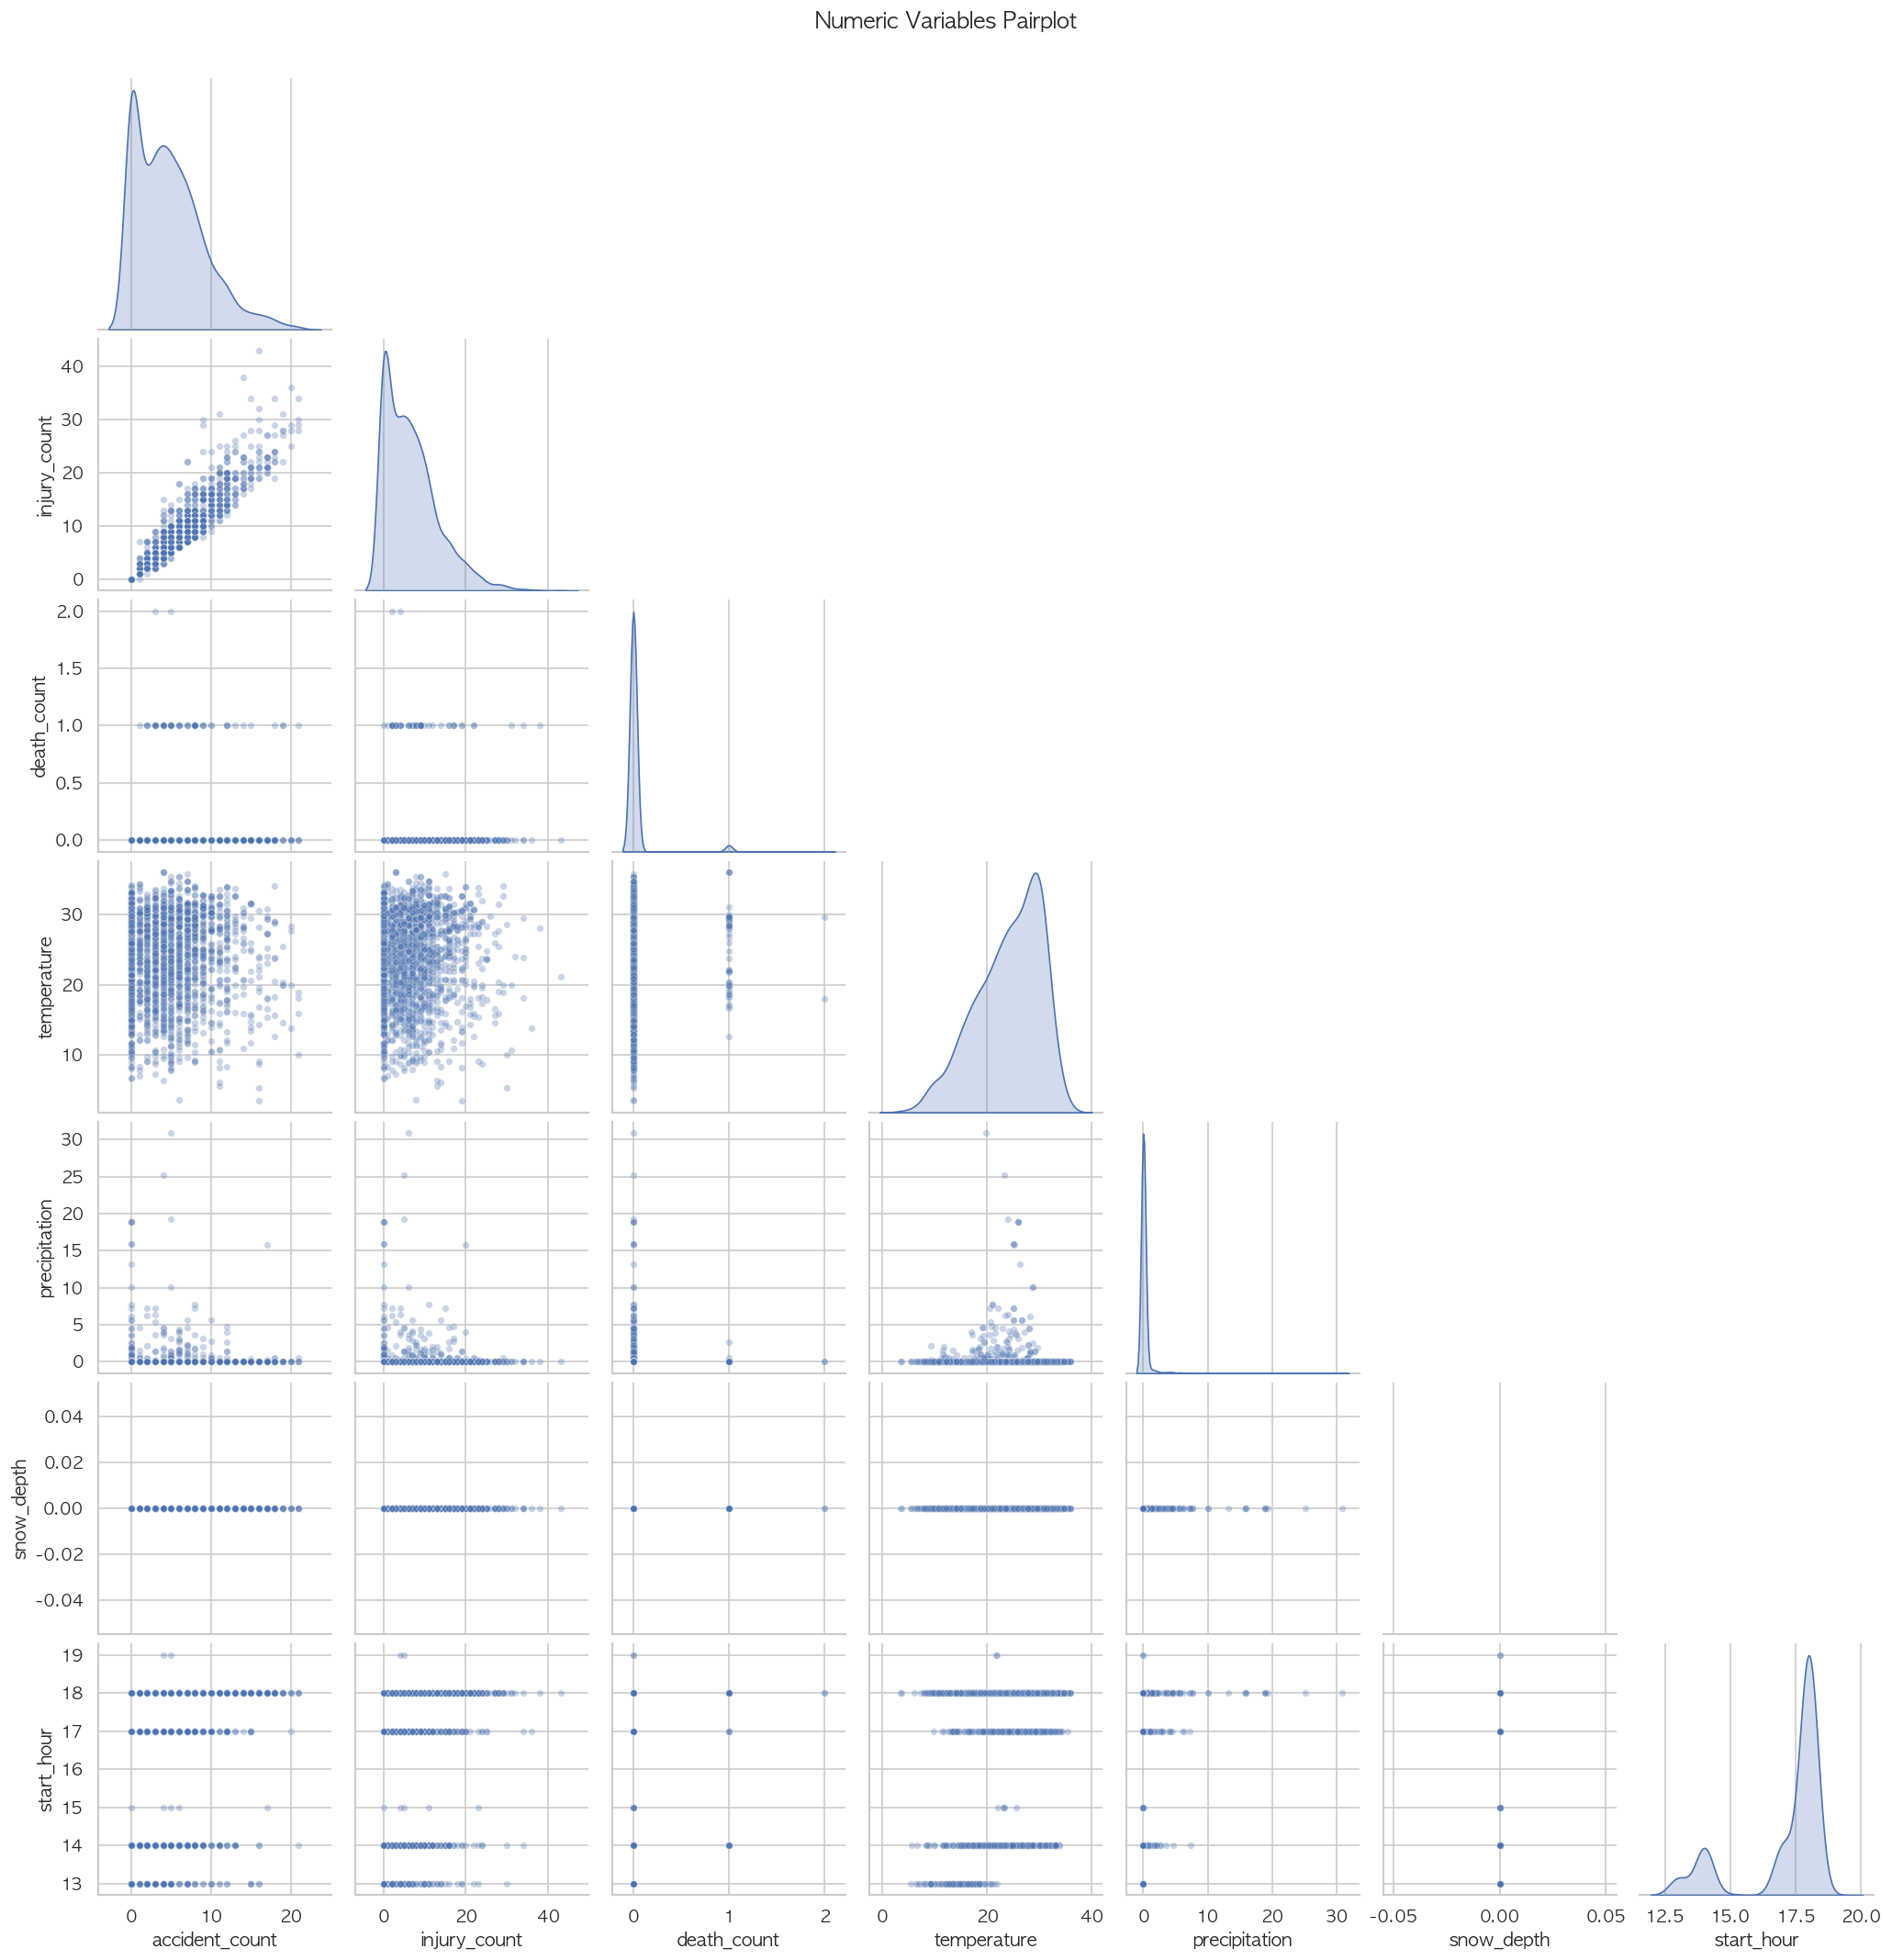

In [44]:
# -------------------- 3-6. 다중 상관 Pairplot ----------------
sns.pairplot(df[["accident_count"] + num_cols], diag_kind="kde",
             corner=True, plot_kws={'alpha':0.3, 's':20})
plt.suptitle("Numeric Variables Pairplot", y=1.02); plt.show()

/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_54477/1369971782.py:11: UserWarning: Glyph 45436 (\N{HANGUL SYLLABLE NON}) missing from font(s) Arial.
  plt.title("논리 위반 레코드"); plt.tight_layout(); plt.show()
/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_54477/1369971782.py:11: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.title("논리 위반 레코드"); plt.tight_layout(); plt.show()
/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_54477/1369971782.py:11: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) Arial.
  plt.title("논리 위반 레코드"); plt.tight_layout(); plt.show()
/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_54477/1369971782.py:11: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) Arial.
  plt.title("논리 위반 레코드"); plt.tight_layout(); plt.show()
/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_54477/1369971782.py:11: UserWarning: Glyph 47112 (\N{HANGUL SYLLABL

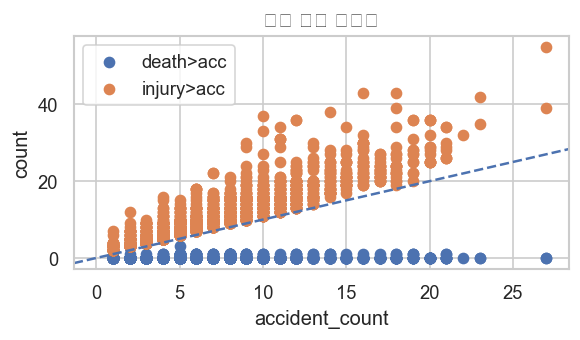

In [16]:
# -------------------- 3-7. 이상치·논리제약 -------------------
# 사망·부상 > 사고건수 레코드 표시
viol = df[(df["death_count"] > df["accident_count"])
          | (df["injury_count"] > df["accident_count"])]
if not viol.empty:
    plt.figure(figsize=(5,3))
    plt.scatter(viol["accident_count"], viol["death_count"], label="death>acc")
    plt.scatter(viol["accident_count"], viol["injury_count"], label="injury>acc")
    plt.axline((0,0),(1,1), linestyle="--"); plt.legend()
    plt.xlabel("accident_count"); plt.ylabel("count")
    plt.title("논리 위반 레코드"); plt.tight_layout(); plt.show()

In [22]:
# 포아송 분포를 이용한 

from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf

rs = df.query("match_type == '정규시즌'")
ps = df.query("match_type == '포스트시즌'")

# 경기당 평균·신뢰구간(부트스트랩) ───────────────
def bootstrap_mean(series, n_boot=5000):
    boot = np.random.choice(series, (n_boot, len(series)), replace=True).mean(axis=1)
    return boot.mean(), np.percentile(boot, [2.5, 97.5])

rs_mu, rs_ci = bootstrap_mean(rs["accident_count"])
ps_mu, ps_ci = bootstrap_mean(ps["accident_count"])
print(f"RS μ={rs_mu:.2f} ({rs_ci[0]:.2f}–{rs_ci[1]:.2f})")
print(f"PS μ={ps_mu:.2f} ({ps_ci[0]:.2f}–{ps_ci[1]:.2f})")

# 비모수 검정 ──────────────────────────────────
u, p = mannwhitneyu(ps["accident_count"], rs["accident_count"], alternative='two-sided')
print(f"Mann-Whitney U p-value = {p:.4f}")

# Poisson 회귀(경기수 차 고려) ────────────────
# 사고 건수를 종속변수, match_type(PS vs RS) 더미만 고려한 단순 모델
df["is_PS"] = (df["match_type"] == "포스트시즌").astype(int)
model = smf.glm("accident_count ~ is_PS", data=df,
                family=sm.families.Poisson()).fit()
print(model.summary())
rr = np.exp(model.params["is_PS"])
ci_low, ci_high = np.exp(model.conf_int().loc["is_PS"])
print(f"Incidence-Rate-Ratio (IRR) = {rr:.2f} ({ci_low:.2f}–{ci_high:.2f})")

RS μ=nan (nan–nan)
PS μ=nan (nan–nan)
Mann-Whitney U p-value = nan
                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_count   No. Observations:                 1611
Model:                            GLM   Df Residuals:                     1609
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4658.5
Date:                Wed, 04 Jun 2025   Deviance:                       3703.1
Time:                        11:09:04   Pearson chi2:                 3.89e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01673
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------